In [1]:
import nltk
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split

nltk.download('stopwords')
nltk.download('punkt')
nltk.download('punkt_tab')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Саня\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Саня\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\Саня\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

## Загрузка данных

In [2]:
data = pd.read_csv("Tweets.csv")
data.head()

,textID,text,selected_text,sentiment
0,cb774db0d1,"I`d have responded, if I were going","I`d have responded, if I were going",neutral
1,549e992a42,Sooo SAD I will miss you here in San Diego!!!,Sooo SAD,negative
2,088c60f138,my boss is bullying me...,bullying me,negative
3,9642c003ef,what interview! leave me alone,leave me alone,negative
4,358bd9e861,"Sons of ****, why couldn`t they put them on t...","Sons of ****,",negative


In [3]:
data.drop(columns=['textID', 'selected_text'], inplace=True)
data = data.dropna(axis=0).reset_index(drop=True)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27480 entries, 0 to 27479
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   text       27480 non-null  object
 1   sentiment  27480 non-null  object
dtypes: object(2)
memory usage: 429.5+ KB


## Разделение на тренировочную и тестовую выборку

In [4]:
y_factorized = pd.factorize(data['sentiment'])[0]
train_data, test_data = train_test_split(data, stratify=y_factorized, random_state=42)

## EDA
### Посмотрим на распределение классов. Присутствует незначительный дисбаланс

<Axes: >

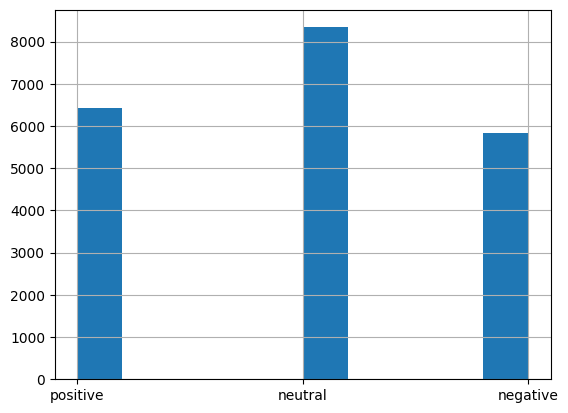

In [5]:
train_data['sentiment'].hist()

### Облако слов

Отобразим распределение самых часто встречающихся слов по классам. Не будем учитывать стоп слова и самые часто встречающиеся слова в датасете (чьё количество превышает 99.5 перцентиль)

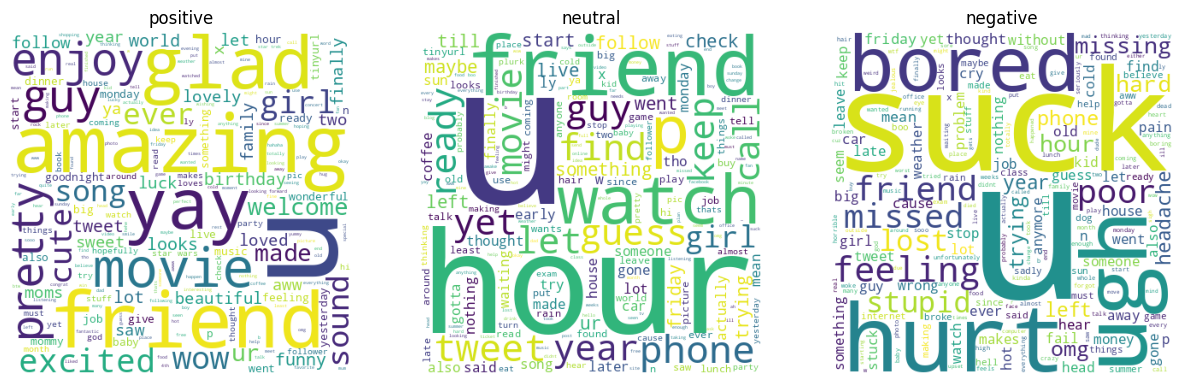

In [6]:
from wordcloud import WordCloud
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer
import matplotlib.pyplot as plt

stop_words = stopwords.words('english')

vectorizer = CountVectorizer(stop_words=stop_words)
word_counts = np.asarray(vectorizer.fit_transform(train_data['text']).sum(0)).squeeze()

percentil_99 = np.percentile(word_counts, 99.5)
most_freq_inds = np.nonzero(word_counts > percentil_99)[0]

w2i_vocab = {v: k for k, v in vectorizer.vocabulary_.items()}

for ind in most_freq_inds:
    stop_words.append(w2i_vocab[ind])

stop_words = set(stop_words)
classes = train_data['sentiment'].unique()

fig, axes = plt.subplots(1, 3, figsize=(15, 15))
for i, cls in enumerate(classes):
    cls_data = train_data[train_data['sentiment'] == cls]['text']
    cls_str = ' '.join(cls_data.to_list()).lower()
    cloud = WordCloud(stopwords=stop_words, height=400, background_color='white').generate(cls_str)
    axes[i].imshow(cloud)
    axes[i].set_title(cls)
    axes[i].axis("off")
 
plt.show()

Как можно видеть, распределение слов отличается в зависимости от класса.

### Распределение по длине

Минимальная длина: 1. Максимальная длина: 56


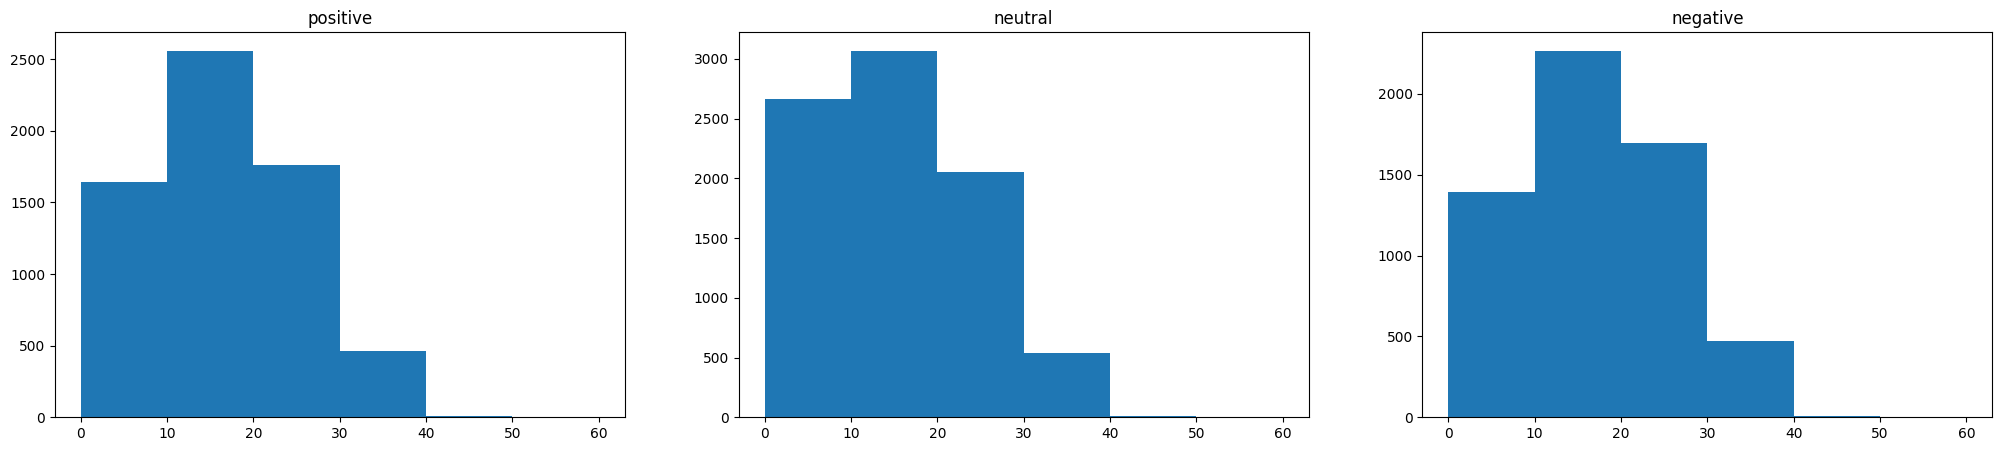

In [7]:
from nltk.tokenize import word_tokenize

text_lens = train_data['text'].apply(word_tokenize).apply(len)

print(f'Минимальная длина: {text_lens.min()}. Максимальная длина: {text_lens.max()}')

fig, axes = plt.subplots(1, 3, figsize=(25, 5))
bins = list(range(0, text_lens.max() + 10, 10))
for i, cls in enumerate(classes):
    cls_lens = text_lens[train_data['sentiment'] == cls]
    axes[i].hist(cls_lens, bins)
    axes[i].set_title(cls)

Распределение по длине почти не отличается между классами. У нейтрального класса больше коротких примеров

## Очистка данных

In [8]:
import re
from nltk.tokenize import word_tokenize
import pymorphy3

def clear_data(df, stopwords):
    morph = pymorphy3.MorphAnalyzer()
    df['text'] = df['text'].apply(lambda text: text.lower())
    df['text'] = df['text'].apply(lambda text: re.sub('[?!@#$1234567890#—ツ►๑۩۞۩•*”˜˜”)*°(°*``,.]', '', text))
    
    df['text'] = df['text'].apply(lambda text: word_tokenize(text))
    df['text'] = df['text'].apply(lambda text: [morph.parse(word)[0].normal_form for word in text if word not in stopwords])
    df['text'] = df['text'].apply(lambda text: ' '.join(text))
    return df

In [9]:
stop_words = stopwords.words('english')
train_data = clear_data(train_data, stop_words)
train_data.head()

,text,sentiment
2198,thank yoou twittertakeover,positive
9218,didnt burn eggs blast food great weekend aweso...,positive
25823,watch,neutral
8814,oh duhi see thank,positive
24324,honestly folks microsoft ms word cant believe ...,neutral


In [10]:
test_data = clear_data(test_data, stop_words)

In [11]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVC
from sklearn.metrics import classification_report


vectorizer = TfidfVectorizer(max_features=10000, ngram_range=(1,1))
train_X = vectorizer.fit_transform(train_data['text'])
train_y = pd.factorize(train_data['sentiment'], sort=True)[0]

test_X = vectorizer.transform(test_data['text'])
test_y = pd.factorize(test_data['sentiment'], sort=True)[0]

classifier = SVC()

classifier.fit(train_X, train_y)

preds = classifier.predict(test_X)

In [12]:
print(classification_report(preds, test_y))

              precision    recall  f1-score   support

           0       0.56      0.76      0.64      1420
           1       0.80      0.61      0.69      3665
           2       0.67      0.80      0.73      1785

    accuracy                           0.69      6870
   macro avg       0.68      0.72      0.69      6870
weighted avg       0.72      0.69      0.69      6870

